In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
nlp = spacy.load("en_core_web_sm")
import gensim
import matplotlib.pyplot as plt
import plotly
import datetime
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob 
import re
from collections import Counter
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/netflix-shows/netflix_titles.csv


In [2]:
data = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
# IMDb_titles = pd.read_csv("/kaggle/input/imdb-dataset/title.basics.tsv/title.basics.tsv", sep = "\t")
# IMDb_name = pd.read_csv("/kaggle/input/imdb-dataset/name.basics.tsv/name.basics.tsv", sep = "\t")

In [3]:
data.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [4]:
genres = []
for row in data.listed_in.str.split(","):
    for el in row:
        genres.append(el)
genres = pd.Series(genres)
genres.shape

(13670,)

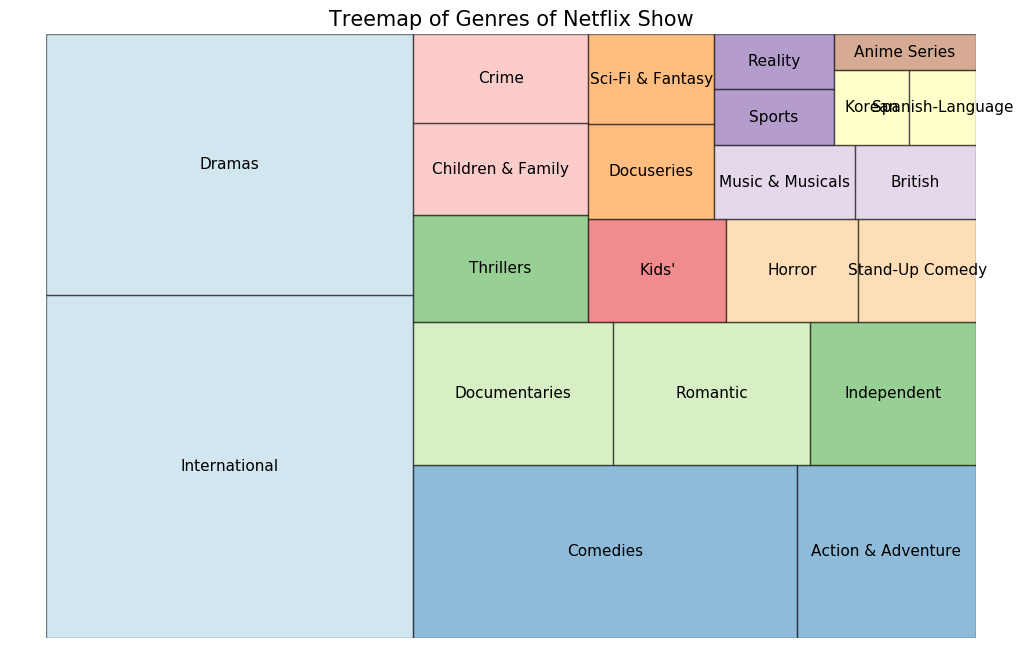

In [5]:
# bold('**MOST POPULAR GENRES ON NETFILX ARE:**')
# bold('**DOCUMENTARIES,COMEDIES, DRAMAS, INTERNATIONAL, ACTION**')
import squarify
# data['Genres'] = data['listed_in'].str.extract('([A-Z]\w{2,})', expand=True)
genres = []
for row in data.listed_in.str.replace("Movies","").str.replace("TV Shows", "").str.replace("TV", "").str.split(","):
    for el in row:
        genres.append(el.strip())
genres = pd.DataFrame(genres)
genres.columns = ['Genres']
temp_df = genres['Genres'].value_counts().reset_index()
temp_df = temp_df[temp_df['Genres'] >= 100]
sizes=np.array(temp_df['Genres'])
labels=temp_df['index']
colors = [plt.cm.Paired(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color = colors, alpha=.5, edgecolor="black", linewidth=1, text_kwargs={'fontsize':11})
plt.title('Treemap of Genres of Netflix Show', fontsize = 15)
plt.axis('off')
plt.show()
# px.treemap(temp_df, values = "Genres")

From the above Tree Map we can say that Drama and International TV Shows are the dominant genre on Netflix

In [6]:
temp_df = data.query("type == 'Movie'")
temp_df['duration'] = temp_df['duration'].str.replace(" min","").str.strip()
temp_df['rating'] = temp_df['rating'].fillna("NA")
temp_df['release_year'] = temp_df['release_year'].astype('str')
temp_df.duration = temp_df.duration.astype('int')
temp_df['Genre'] = temp_df.listed_in.apply(lambda x: x.split(",")[0].replace("Movies","").replace("TV Shows","").replace("TV","").strip())
temp_df = temp_df.groupby(['Genre']).mean().reset_index()
fig = px.line_polar(temp_df,r = "duration", theta = "Genre", line_close = True, template = "plotly_dark")
fig.update_layout(title = "How Duration varies with Genre")
fig.show()

The Above Radar shows the relationship between genre and the run time of the movie. We can clearly see Dramas, Classics take shortest runtime!

In [7]:
temp_df = data.query("type == 'TV Show'")
temp_df['duration'] = temp_df['duration'].str.replace(" Seasons","").str.replace(" Season","").str.strip()
temp_df.head()
# temp_df['rating'] = temp_df['rating'].fillna("NA")
# temp_df['release_year'] = temp_df['release_year'].astype('str')
# temp_df['']
temp_df.duration = temp_df.duration.astype('int')
temp_df['Genre'] = temp_df.listed_in.apply(lambda x: x.split(",")[0].replace("Movies","").replace("TV Shows","").replace("TV","").strip())
temp_df = temp_df.groupby(['Genre']).mean().reset_index()
fig = px.line_polar(temp_df,r = "duration", theta = "Genre", line_close = True, template = "plotly_dark")
fig.update_layout(title = "How Seasons varies with Genre")
# fig.show()

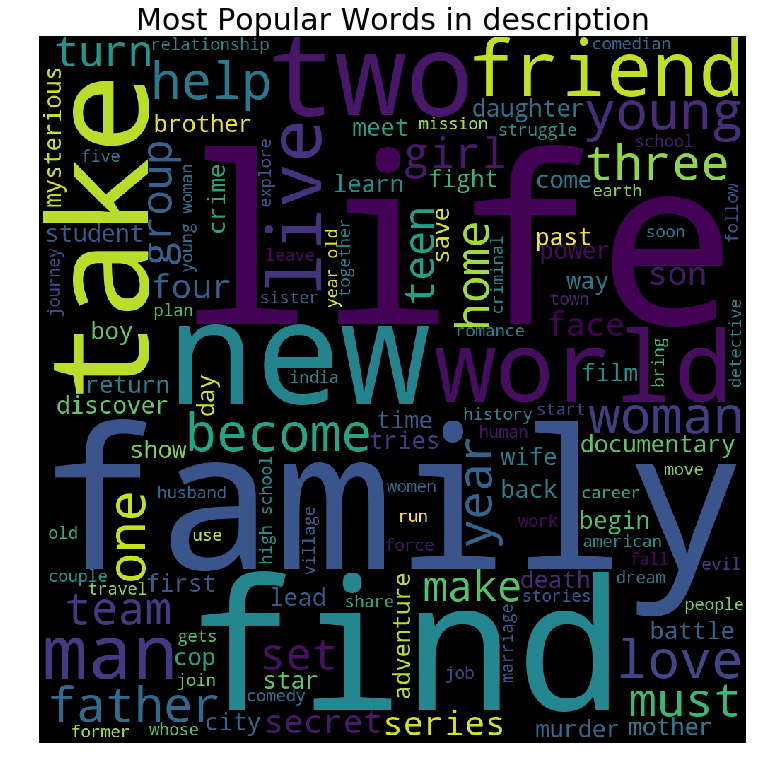

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width = 1000,  height = 1000, max_words = 121).generate((' '.join(data['description']).lower()))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words in description',fontsize = 30)
plt.show()